# Model Analysis

Scale up the vanilla model to larger dataset

UPDATED:
Scrapped through 179,566 comments from 1834 articles from the New York Times. (January ~ March 2020 articles), from 29 different main categories. Obituaries, crosswords, revision articles (i.e. revised because previous publication had an error), real estate, weddings, arts and parenting are excluded because they do not have comments.

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy import stats
from statsmodels.formula.api import ols

In [4]:
os.getcwd()

'C:\\Users\\bolim\\Desktop\\Thesis\\thesis_github'

In [7]:
# Read in the total data
df_ttl = pd.read_csv('data/ttl_df.csv')

In [8]:
print(df_ttl.shape)
print(df_ttl.columns) 
# category is the raw category, category_ is reclassified to upper level
# i.e. world/middleeast, world/africa -> world

(179566, 19)
Index(['userName', 'cleanName', 'comment', 'n_recommend', 'n_reply',
       'nyt_select', 'ttlCommentNum', 'time', 'time_order', 'time_order_cap',
       'url', 'n_rec_log', 'ttl_comment_log', 'gender', 'date', 'category',
       'category_', 'yhat_model1', 'residual_model1'],
      dtype='object')


In [49]:
# Gender sizes? 
genders = df_ttl.groupby(['gender']).size().reset_index(name='count')
genders['perc'] = genders['count']/179566 * 100
genders

,gender,count,perc
0,0,75038,41.788535
1,1,30948,17.234889
2,2,73580,40.976577


# Run Model:
`n_rec_log ~ C(gender) + C(nyt_select) + ttl_comment_log + time_order_cap`

_`time_order_cap` capped to 50, previously 25_

In [11]:
# Run the model on a larger data
model1 = ols('n_rec_log ~ C(gender) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df_ttl).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                 1.283e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:46:06   Log-Likelihood:            -2.9363e+05
No. Observations:              179566   AIC:                         5.873e+05
Df Residuals:                  179560   BIC:                         5.873e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.78

Note: 

When larger data is used, compared with the smaller dataset, being a "women" is _**not**_ a minus; it is actually a plus. This is quite... different from what initial models with a smaller dataset showed.

Moreover, gender becomes even _statistically significant_. It is true that a lot _less_ women write the comments (only 17%)

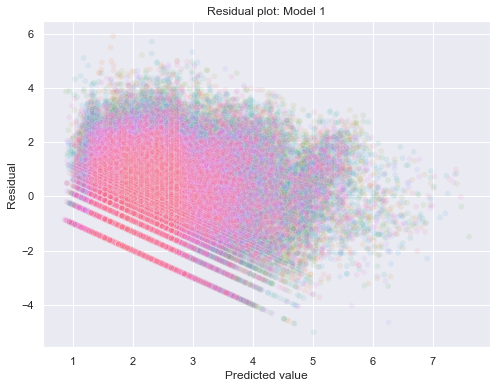

In [14]:
## :::::: MODEL 1 ::::::
# Residual plot
# 1) Prep data
df_ttl['yhat_model1'] = model1.fittedvalues
df_ttl['residual_model1'] = df_ttl['n_rec_log'] - model1.fittedvalues

# 2) Plot residual plot
# Coloring by article (url)
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model1', y='residual_model1', data=df_ttl, hue='url', alpha = 0.1)
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Residual')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Residual plot: Model 1')

# Bootstrapping - Article Level

Residual plot shows that articles with too little actual comments to start with may receive little to none recommendations. I wanted to see where the outlier level lies so that I can bootstrap and run the model again.

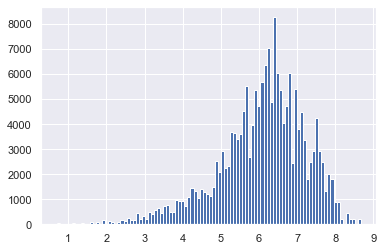

In [16]:
_ = plt.hist(df_ttl['ttl_comment_log'], bins = 100)
_ = plt.show()

In [19]:
tmp_df = df_ttl.drop_duplicates(subset = 'url')
ttl_comment_array = np.asarray(tmp_df['ttl_comment_log'].values.tolist())

lower = np.empty(10000)

for i in range(10000):
    bs_sample = np.random.choice(ttl_comment_array, size = len(ttl_comment_array))
    lower[i] = np.percentile(bs_sample, [5])
lower_mean = np.mean(lower)

print(lower_mean)

1.5474017002428282


In [21]:
df_ttl2 = df_ttl[df_ttl['ttl_comment_log'] > 1.5474017002428282]
df_ttl2.shape # 158 rows removed

(179408, 19)

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                 1.278e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:38:16   Log-Likelihood:            -2.9339e+05
No. Observations:              179408   AIC:                         5.868e+05
Df Residuals:                  179402   BIC:                         5.869e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.79

C:\Users\bolim\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bolim\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


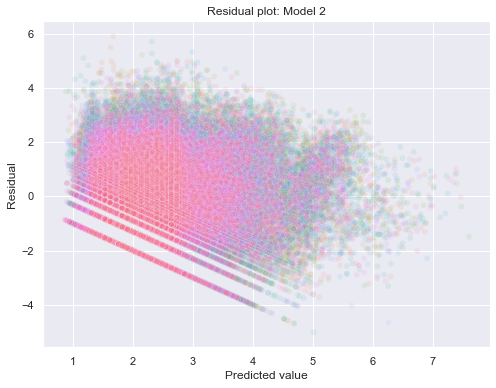

In [32]:
# Run the model on a larger data
model2 = ols('n_rec_log ~ C(gender) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df_ttl2).fit()
print(model2.summary())

## :::::: MODEL 2 ::::::
# Residual plot
# 1) Prep data
df_ttl2['yhat_model2'] = model2.fittedvalues
df_ttl2['residual_model2'] = df_ttl2['n_rec_log'] - model2.fittedvalues

# 2) Plot residual plot
# Coloring by article (url)
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model1', y='residual_model1', data=df_ttl2, hue='url', alpha = 0.1)
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Residual')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Residual plot: Model 2')

Bootstrapping at article level, does not yield much difference. Variability might occur from different topics. Some topics are more 'female' friendly (such as fashion) whereas some topics are regarded 'masculine' (business, politics etc.) 

# Add interaction : Gender & Category

In [38]:
# Run the model on a larger data
model3 = ols('n_rec_log ~ C(gender):C(category_) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df_ttl).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1197.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:46:14   Log-Likelihood:            -2.7920e+05
No. Observations:              179566   AIC:                         5.586e+05
Df Residuals:                  179476   BIC:                         5.595e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Compare with a randomly generated numbers list to compare if the article interaction term indeed improve describing the variability. 

In [40]:
random_list = []

for i in range(len(df_ttl)):
    random_list.append(np.random.randint(1,30))

df_ttl['random'] = random_list

In [73]:
# Run the model on a larger data
model = ols('n_rec_log ~ C(gender):C(random) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df_ttl).fit()
print(model.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     721.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:27:09   Log-Likelihood:            -2.9360e+05
No. Observations:              179566   AIC:                         5.874e+05
Df Residuals:                  179476   BIC:                         5.883e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         


Adding the categories does imporve variability in the dataset. Go on with the model with categories added.

### Residuals, Categories added

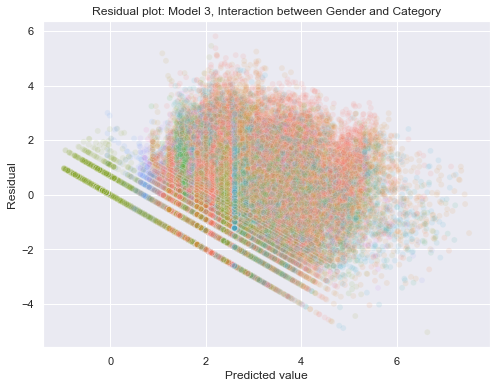

In [39]:
## :::::: MODEL 3 ::::::
# Residual plot
# 1) Prep data
df_ttl['yhat_model3'] = model3.fittedvalues
df_ttl['residual_model3'] = df_ttl['n_rec_log'] - model3.fittedvalues

# 2) Plot residual plot
# Coloring by article (url)
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model3', y='residual_model3', data=df_ttl, hue = 'category_', alpha = 0.1)
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Residual')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Residual plot: Model 3, Interaction between Gender and Category')

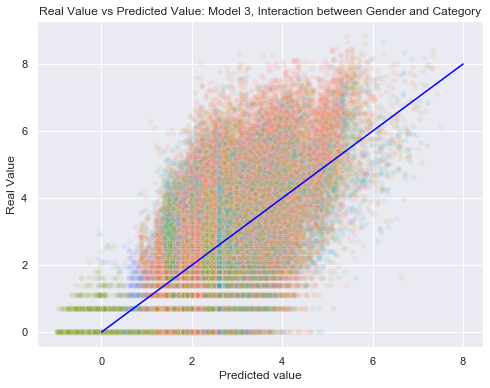

In [48]:
# Model 3, y vs yhat

sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model3', y='n_rec_log', data=df_ttl, hue = 'category_', alpha = 0.1)
_ = plt.plot([0,8], [0,8], color = 'blue')
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Real Value')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Real Value vs Predicted Value: Model 3, Interaction between Gender and Category')

### Point to CONSIDER : TOO FEW OBSERVATIONS?

What if there are not enough variables to predict from? If gender & category is used together, are there enough observations for each category?

In [53]:
gender_cat = df_ttl.groupby(['gender', 'category_']).size().reset_index(name='count')
gender_cat[gender_cat['count'] < 30]

,gender,category_,count
5,0,education,19
34,1,education,2
35,1,fashion,26
51,1,the-weekly,17
63,2,education,11
80,2,the-weekly,27


Remove all articles from education, fashion, the-weekly to make it more robust.

In [55]:
df_ttl3 = df_ttl[(df_ttl['category_'] != 'education') &
                (df_ttl['category_'] != 'fashion') &
                (df_ttl['category_'] != 'the_weekly')]

In [56]:
# Run the model on a larger data
model3_removed = ols('n_rec_log ~ C(gender):C(category_) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df_ttl3).fit()
print(model3_removed.summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1284.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:11:21   Log-Likelihood:            -2.7896e+05
No. Observations:              179403   AIC:                         5.581e+05
Df Residuals:                  179319   BIC:                         5.589e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\bolim\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\bolim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


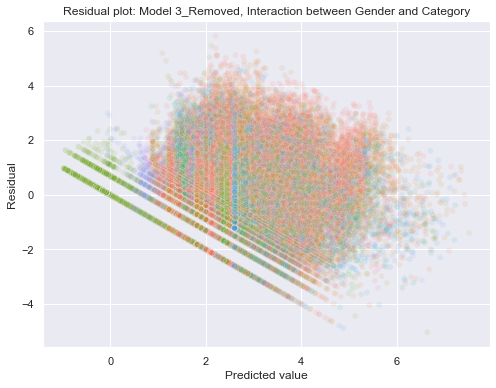

In [57]:
## :::::: MODEL 3_REMOVED ::::::
# Residual plot
# 1) Prep data
df_ttl3['yhat_model3'] = model3_removed.fittedvalues
df_ttl3['residual_model3'] = df_ttl['n_rec_log'] - model3_removed.fittedvalues

# 2) Plot residual plot
# Coloring by article (url)
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model3', y='residual_model3', data=df_ttl3, hue = 'category_', alpha = 0.1)
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Residual')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Residual plot: Model 3_Removed, Interaction between Gender and Category')

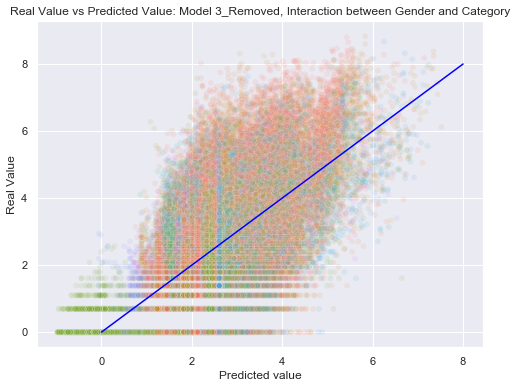

In [58]:
# Model 3, y vs yhat

sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model3', y='n_rec_log', data=df_ttl3, hue = 'category_', alpha = 0.1)
_ = plt.plot([0,8], [0,8], color = 'blue')
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Real Value')
_ = ax.get_legend().set_visible(False)
_ = plt.title('Real Value vs Predicted Value: Model 3_Removed, Interaction between Gender and Category')

Removing values with little observations does not really affect (improve) the results, given that there are already lots of observations to start with. Coefficients also display similar behavior.

In contrast with the vanilla model with a few observations, it seems that if you are a 'female', the recommendation behaviors are 'amplified' - for example, if it is 0.1 with men, it is 0.1 + 0.02 with women. This display is same for with/without article category added.

Even for traditionally 'masculine' subjects such as business, tech, science, and sports, women are more likely to get recommendations. I thougth this behavior was exaggerated because there were too few observations, but even after the "few" observations are filtered out, results are the same. 

# Bootstrap - Beta Values

In [79]:
# Prepare data - extract only the necessary columns
df_bs = df_ttl3[['n_rec_log', 'gender', 'nyt_select', 'ttl_comment_log', 'time_order_cap', 'category_']]

In [109]:
bs_coef_result = pd.DataFrame()

simulation_size = 10

for i in range(simulation_size):
    bs_sample = df_bs.sample(n=df_bs.shape[0], replace = True)
    tmp_model = ols('n_rec_log ~ C(gender):C(category_) + C(nyt_select) + ttl_comment_log + time_order_cap', data = bs_sample).fit()
    tmp_coef_df = pd.read_html(tmp_model.summary().tables[1].as_html(),header=0,index_col=0)[0]
    tmp_coef_df['simulation_num'] = i+1
    tmp_coef_df = tmp_coef_df.reset_index() # index to columns
    bs_coef_result = bs_coef_result.append(tmp_coef_df, ignore_index=True)

In [110]:
df = bs_coef_result[['index', 'coef']].groupby('index').quantile([.025, .975]).reset_index()
df.head()

,index,level_1,coef
0,C(category_)[T.books],0.025,0.187082
1,C(category_)[T.books],0.975,0.465213
2,C(category_)[T.business],0.025,0.236118
3,C(category_)[T.business],0.975,0.478160
4,C(category_)[T.climate],0.025,0.259197


In [111]:
df.pivot(index='index', columns = 'level_1', values='coef')

level_1,0.025,0.975
index,,
C(category_)[T.books],0.187082,0.465213
C(category_)[T.business],0.236118,0.478160
C(category_)[T.climate],0.259197,0.452705
C(category_)[T.dining],-0.007142,0.203140
C(category_)[T.health],0.157360,0.357058
...,...,...
C(gender)[T.2]:C(category_)[world],-0.037527,0.020882
C(nyt_select)[T.True],2.759695,2.810188
Intercept,0.629675,0.842645


In [112]:
bs_coef_result.groupby(['index'])['coef'].agg(np.mean).reset_index()

,index,coef
0,C(category_)[T.books],0.29997
1,C(category_)[T.business],0.34660
2,C(category_)[T.climate],0.35877
3,C(category_)[T.dining],0.09924
4,C(category_)[T.health],0.25624
...,...,...
79,C(gender)[T.2]:C(category_)[world],-0.00072
80,C(nyt_select)[T.True],2.78411
81,Intercept,0.74982
82,time_order_cap,-0.03852
